In [5]:
import os

from time import time
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
from os.path import join
import re
from multiprocessing import Pool

from tqdm import tqdm

from shapely import Point
import matplotlib.pyplot as plt


In [6]:
# if "client" not in locals():
#     cluster = LocalCluster(n_workers=48, threads_per_worker=1, memory_limit="4GB")
#     client = Client(cluster)
# else:
#     print("client already exists")
# print(client)

## Collect file names

In [7]:
base_path = "/home/patel_zeel/OpenAQ/PurpleAir"

if os.path.exists(join(base_path, "all_files.txt")):
    print("all_files.txt already exists. Reading it...")
    # read all files
    with open(join(base_path, "all_files.txt"), "r") as f:
        all_files = f.read().split("\n")
else:
    print("all_files.txt does not exist. Creating it...")
    # recursively read all files in the directory
    all_files = glob(join(base_path, "**/*.csv.gz"), recursive=True)
    with open(join(base_path, "all_files.txt"), "w") as f:
        f.write("\n".join(all_files))

files_df = pd.DataFrame(all_files, columns=["file_path"])
print(files_df.head(2))
print(files_df.shape)

all_files.txt already exists. Reading it...
                                           file_path
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...
(7554025, 1)


In [8]:
file = np.random.choice(all_files)
print(file)
tmp_df = pd.read_csv(file)
print(tmp_df["parameter"].value_counts())
tmp_df

/home/patel_zeel/OpenAQ/PurpleAir/data/locationid=63637/year=2022/month=05/location-63637-20220504.csv.gz
parameter
pm10     444
pm25     444
pm1      444
um010    444
um025    444
um100    444
Name: count, dtype: int64


,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,63637,396198,SCTV_26-58635,2022-05-04T00:07:11-07:00,33.75318,-117.468864,pm10,µg/m³,16.2
1,63637,396198,SCTV_26-58635,2022-05-04T00:09:11-07:00,33.75318,-117.468864,pm10,µg/m³,15.6
2,63637,396198,SCTV_26-58635,2022-05-04T00:13:11-07:00,33.75318,-117.468864,pm10,µg/m³,15.2
3,63637,396198,SCTV_26-58635,2022-05-04T00:23:11-07:00,33.75318,-117.468864,pm10,µg/m³,14.6
4,63637,396198,SCTV_26-58635,2022-05-04T00:29:11-07:00,33.75318,-117.468864,pm10,µg/m³,15.8
...,...,...,...,...,...,...,...,...,...
2659,63637,1166738,SCTV_26-58635,2022-05-04T23:51:26-07:00,33.75318,-117.468864,um100,particles/cm³,0.0
2660,63637,1166738,SCTV_26-58635,2022-05-04T23:53:26-07:00,33.75318,-117.468864,um100,particles/cm³,0.0
2661,63637,1166738,SCTV_26-58635,2022-05-04T23:55:26-07:00,33.75318,-117.468864,um100,particles/cm³,0.0
2662,63637,1166738,SCTV_26-58635,2022-05-04T23:57:26-07:00,33.75318,-117.468864,um100,particles/cm³,0.0


## Load California Shapefile

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.65560 39.69357, -120.65554 39.6..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-121.18858 38.71431, -121.18732 38.7..."


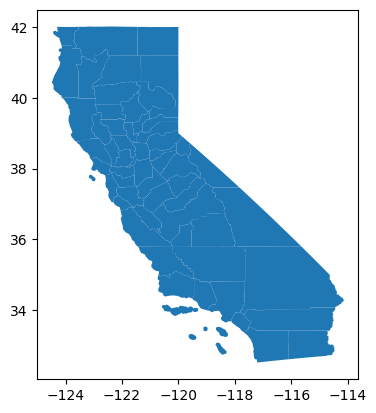

In [9]:
# download california state shapefile
import geopandas as gpd

california = gpd.read_file(
    "/home/patel_zeel/aq_data/aq_data/purpleair/raw/shapefiles/CA_Counties_TIGER2016.shp"
)
# set the crs to 4326 (lat/lon)
california = california.to_crs(epsg=4326)
california.plot()
california.head(2)

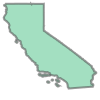

In [10]:
# convert all regions into a single polygon
poly = california["geometry"].unary_union
poly

In [11]:
# get the bounding box of the polygon
poly.bounds

(-124.48201686078049,
 32.52883673637251,
 -114.13122247508855,
 42.00950826967187)

## Find locations within California

In [7]:
# find all location ids from file names. Use `locationid` in regex for searching
init = time()
files_df["location_id"] = files_df.file_path.apply(
    lambda x: int(re.findall(r"locationid=(\d+)", x)[0])
)
print(f"Time taken: {time() - init:.2f} seconds")

unique_files_df = files_df.drop_duplicates(subset=["location_id"])

unique_files = unique_files_df.file_path.values
print("Unique files:", len(unique_files))

unique_locations = (
    unique_files_df["file_path"]
    .apply(lambda x: re.findall(r"locationid=(\d+)", x)[0])
    .values
)
assert len(set(unique_locations)) == len(unique_locations)


Time taken: 10.58 seconds
Unique files: 22497


In [8]:
print(files_df.head(2))
files_df.dtypes


                                           file_path  location_id
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873


file_path      object
location_id     int64
dtype: object

In [9]:
def get_metadata(file_name):
    df = pd.read_csv(file_name)
    lat = df["lat"].iloc[0]
    lon = df["lon"].iloc[0]
    location_id = df["location_id"].iloc[0]
    point = Point(lon, lat)
    in_california = poly.contains(point)
    return {
        "in_california": in_california,
        "latitude": lat,
        "longitude": lon,
        "location_id": location_id,
    }


with_dask = False
with_multiprocessing = True
init = time()

if with_dask:
    delayed_fn = dask.delayed(get_metadata)
else:
    delayed_fn = get_metadata

metadata_path = join(base_path, "metadata.nc")
print(metadata_path)
if os.path.exists(metadata_path):
    print("metadata already exists. Reading it...")
    metadata_ds = xr.open_dataset(metadata_path)
else:
    print("metadata does not exist. Creating it...")
    # took 1 minute to run
    metadata = []

    if with_multiprocessing:
        print("Running multiprocessing...")
        with Pool(48) as p:
            metadata = list(
                tqdm(
                    p.imap(delayed_fn, unique_files_df.file_path.values),
                    total=len(unique_files_df),
                )
            )
    else:
        print("Running delayed function...")
        for file in unique_files_df.file_path.values:
            metadata.append(delayed_fn(file))

        if with_dask:
            print("Computing...")
            metadata = dask.compute(*metadata)

    metadata_ds = pd.DataFrame(metadata).set_index("location_id").to_xarray()
    metadata_ds.to_netcdf(metadata_path)

print(f"Time taken: {(time() - init)/60} minutes")

metadata_ds = (
    metadata_ds.to_dataframe().reset_index().set_index(["in_california"]).to_xarray()
)
metadata_ds


/home/patel_zeel/OpenAQ/PurpleAir/metadata.nc
metadata already exists. Reading it...
Time taken: 0.00046242475509643554 minutes


<xarray.Dataset>
Dimensions:        (in_california: 22497)
Coordinates:
  * in_california  (in_california) bool True True False ... False True False
Data variables:
    location_id    (in_california) int64 224873 73214 228621 ... 63314 234366
    latitude       (in_california) float64 37.81 37.89 39.12 ... 36.97 44.21
    longitude      (in_california) float64 -122.2 -122.3 ... -122.0 -122.3

In [10]:
in_cal_ds = metadata_ds.sel(in_california=True)
in_cal_df = in_cal_ds.to_dataframe()
print(in_cal_df.head(2))
print(in_cal_df.dtypes)

               location_id   latitude  longitude
in_california                                   
True                224873  37.806890 -122.21374
True                 73214  37.894917 -122.27640
location_id      int64
latitude       float64
longitude      float64
dtype: object


In [11]:
print(files_df.head(2))
files_df.location_id.unique().shape

                                           file_path  location_id
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873


(22497,)

In [12]:
cal_files_df = files_df.merge(in_cal_df, on="location_id", how="inner")
print(cal_files_df.head(2))
print(cal_files_df.shape)
print(cal_files_df.location_id.unique().shape)


                                           file_path  location_id  latitude  \
0  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873  37.80689   
1  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...       224873  37.80689   

   longitude  
0 -122.21374  
1 -122.21374  
(4398787, 4)
(11618,)


## Checking availability statistics

In [13]:
cal_files_df["date"] = cal_files_df.file_path.apply(
    lambda x: re.findall(r"location-\d+-(\d{8})", x)[0]
)
cal_files_df["year"] = cal_files_df["date"].apply(lambda x: int(x[:4]))
cal_files_df["year-month"] = cal_files_df["date"].apply(lambda x: int(x[:6]))
cal_files_df.head(2)

,file_path,location_id,latitude,longitude,date,year,year-month
0,/home/patel_zeel/OpenAQ/PurpleAir/data/locatio...,224873,37.80689,-122.21374,20230312,2023,202303
1,/home/patel_zeel/OpenAQ/PurpleAir/data/locatio...,224873,37.80689,-122.21374,20230330,2023,202303


In [14]:
yearwise_counts = (
    cal_files_df.groupby(["year"])["location_id"]
    .nunique()
    .reset_index()
    .rename(columns={"location_id": "sensor_count"})
)
yearwise_counts


,year,sensor_count
0,2018,4
1,2019,12
2,2020,53
3,2021,9675
4,2022,9924
5,2023,7699


In [15]:
monthwise_counts = (
    cal_files_df.groupby(["year-month"])["location_id"]
    .nunique()
    .reset_index()
    .rename(columns={"location_id": "sensor_count"})
)
monthwise_counts.sort_values("year-month")


,year-month,sensor_count
0,201803,1
1,201807,1
2,201808,1
3,201812,1
4,201903,1
5,201906,5
6,201907,2
7,201909,3
8,201911,1
9,202001,1


In [16]:
loc_data = cal_files_df.groupby(["location_id", "year"])["date"].nunique()
# add lat/lon
loc_data = (
    loc_data.to_frame()
    .reset_index()
    .merge(
        cal_files_df[["location_id", "latitude", "longitude"]].drop_duplicates(),
        on="location_id",
        how="left",
    )
)
loc_data = loc_data.rename(columns={"date": "days"})
loc_data = loc_data.sort_values("days", ascending=False)

print(loc_data.head(2))

     location_id  year  days   latitude  longitude
261        62349  2021   353  37.811360 -122.29959
238        62341  2021   353  37.523067 -122.33837


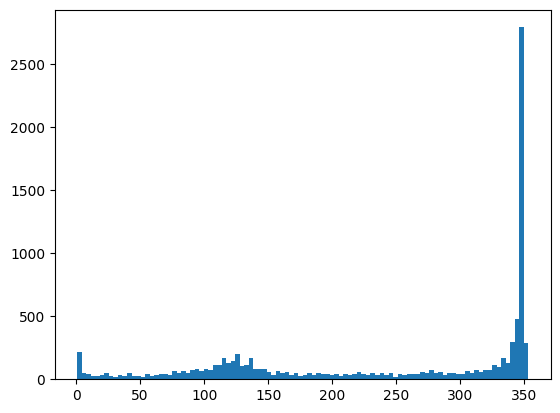

In [17]:
locs_data_2021 = loc_data[loc_data["year"] == 2021]
_ = plt.hist(locs_data_2021["days"], bins=100)


In [18]:
percentage = 90
min_days = int(365 * percentage / 100)
print(f"Minimum days: {min_days}")

loc_suff_data = locs_data_2021[locs_data_2021.days >= min_days]
print(loc_suff_data.shape)
print(loc_suff_data.head(2))


Minimum days: 328
(4286, 5)
     location_id  year  days   latitude  longitude
261        62349  2021   353  37.811360 -122.29959
238        62341  2021   353  37.523067 -122.33837


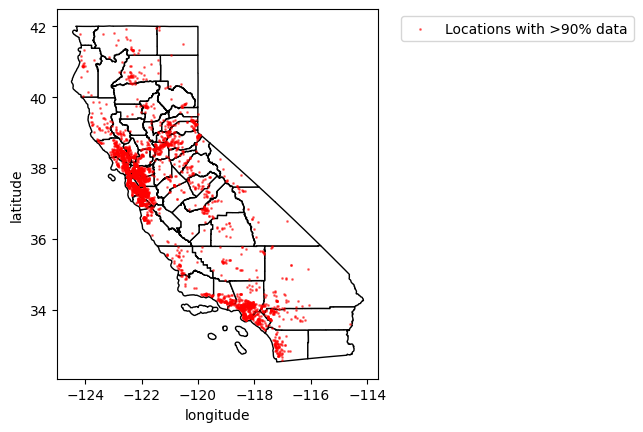

In [19]:
fig, ax = plt.subplots()
california.plot(ax=ax, color="white", edgecolor="black")
loc_suff_data.plot(
    x="longitude",
    y="latitude",
    kind="scatter",
    s=1,
    ax=ax,
    color="red",
    alpha=0.5,
    label=f"Locations with >{percentage}% data",
)
_ = plt.legend(bbox_to_anchor=(1.05, 1))

In [1]:
california

NameError: name 'california' is not defined

In [20]:
suff_data_files = cal_files_df[cal_files_df.location_id.isin(loc_suff_data.location_id)]
suff_data_files = suff_data_files[suff_data_files.year == 2021]
print(suff_data_files.shape)
print(suff_data_files.head(2))


(1479138, 7)
                                             file_path  location_id  \
521  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...        73214   
522  /home/patel_zeel/OpenAQ/PurpleAir/data/locatio...        73214   

      latitude  longitude      date  year  year-month  
521  37.894917  -122.2764  20210727  2021      202107  
522  37.894917  -122.2764  20210723  2021      202107  


## Read and Combine Data

In [21]:
# init = time()
# ddf_list = dask.compute(*[dask.delayed(dd.read_csv)(file, blocksize=None) for file in suff_data_files.file_path.values])
# print(f"Read time: {(time() - init)/60} minutes")

# ddf_combined = dd.concat(ddf_list)
# ddf_combined.head(2)


In [22]:
import gzip
import shutil
from multiprocessing import Pool

save_dir = "/home/patel_zeel/aqmsp/aqmsp_data/data/purpleair/2021"
os.makedirs(save_dir, exist_ok=True)


def extract_gz(file):
    last_name = file.split("/")[-1].replace(".gz", "")
    with gzip.open(file, "rb") as f_in:
        if os.path.exists(join(save_dir, last_name)):
            return 1
        with open(join(save_dir, last_name), "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    return 1


init = time()
with Pool(48) as p:
    _ = list(
        tqdm(
            p.imap(extract_gz, suff_data_files.file_path.values),
            total=len(suff_data_files),
        )
    )

print(f"Time taken: {(time() - init)/60} minutes")

100%|██████████| 1479138/1479138 [01:09<00:00, 21426.76it/s]


Time taken: 1.1845959742863974 minutes


In [23]:
4000 * 365, 1479138


(1460000, 1479138)

For year 2021, above process took around 16 minutes to complete with dask.

## Read all data

In [ ]:
# read all files with pandas in chunks

init = time()
loc = loc_suff_data.location_id.values[0]
dask_df = dd.read_csv(join(save_dir, f"location-{loc}-*.csv"))
print(f"Time taken: {(time() - init)/60} minutes")
dask_df

In [ ]:
def combine_and_save(loc):
    tmp_df = pd.concat(
        [pd.read_csv(f) for f in glob(join(save_dir, f"location-{loc}-*.csv"))]
    )
    tmp_df.to_csv(join(save_dir, f"location-{loc}.csv"), index=False)

In [2]:
%pip install zarr gcsfs

  Obtaining dependency information for gcsfs from https://files.pythonhosted.org/packages/52/e7/9c74a8d032069bf82d9c2a631ed46ffe94be600bd893533668403703bb63/gcsfs-2023.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for fsspec==2023.9.1 from https://files.pythonhosted.org/packages/6a/af/c673e8c663e17bd4fb201a6f029153ad5d7023aa4442d81c7987743db379/fsspec-2023.9.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 7.7 MB/s eta 0:00:00
DEPRECATION: jax-advi LOCAL has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of jax-advi or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: p

In [3]:
import xarray as xr

era5 = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    consolidated=True,
)
era5


<xarray.Dataset>
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>